In [8]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from fancyimpute import KNN
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_score, KFold,train_test_split
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [9]:
df1=pd.read_excel('customers.csv.xlsx', index_col=0)
df2=pd.read_excel('transactions.csv.xlsx')

In [16]:
df2['month_year'] = df2['transaction_date'].dt.strftime('%b-%Y')
df3=df2.reset_index().groupby(['customer_id','month_year']).agg({'transaction_value': 'sum'})
df4= df3.groupby(level=0).apply(lambda x: x.mean()*6).reset_index()
df=df1.merge(df4, on='customer_id', how='right').dropna()

In [17]:
df

,customer_id,state,age,gender,income,is_married,promo_group_1,promo_group_2,customer_loyalty_index,brand_awareness_index,transaction_value
0,0.0,NJ,64.0,Female,65000.0,Y,A,X,0.058849,1.969644e-01,163.800000
1,1.0,NY,26.0,Female,43000.0,Y,A,Z,-4.872865,2.970386e-14,195.866667
3,3.0,ME,18.0,Female,68000.0,N,B,Z,0.152339,2.341961e-03,137.500000
4,4.0,CA,41.0,Female,25000.0,N,A,Y,0.732875,8.073341e-14,164.692941
6,6.0,MA,37.0,Female,140500.0,N,C,X,-0.598321,1.472934e-08,135.700000
...,...,...,...,...,...,...,...,...,...,...,...
63447,63447.0,NY,45.0,Other,142000.0,Y,A,Z,-1.034898,1.197638e+00,71.520000
63448,63448.0,MA,44.0,Male,47500.0,Y,C,Z,-1.759513,2.880281e+00,165.360000
63450,63450.0,NH,43.0,Male,49000.0,N,C,X,1.185524,3.040036e-24,69.660000
63451,63451.0,MA,34.0,Female,86000.0,N,C,X,0.123785,2.898155e-04,166.920000


In [18]:
cat=[]
cont=[]
for i in list(df.columns)[1:]:
    if df[i].dtype=='object':
        df[i]=df[i].apply(lambda x: str(x))
        cat.append(i)    
    else:
        if i=='transaction_value':
            pass
        else:
            cont.append(i)

In [19]:
cat_matrix = OneHotEncoder().fit_transform(df[cat]).toarray()
ohe=OneHotEncoder().fit(df[cat])
new_columns=[]
new_columns=ohe.get_feature_names(cat)
df_cat=pd.DataFrame(cat_matrix, columns=new_columns)
cont_matrix=StandardScaler().fit_transform(df[cont])
df_cont=pd.DataFrame(cont_matrix, columns=[cont])
df_combined = pd.concat([df_cont, df_cat], axis=1)

X=pd.DataFrame(df_combined, columns=df_combined.columns)
y=df['transaction_value'].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
cv = KFold(n_splits=5, shuffle=True, random_state=41)

dt=DecisionTreeRegressor()
rfr = RandomForestRegressor()
abr = AdaBoostRegressor()
gbst = GradientBoostingRegressor()

def score(model, name):
    s = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1,scoring='neg_median_absolute_error')
    print ("{} Score:\t{:0.3} ± {:0.3}".format(name, abs(s.mean().round(5)), s.std().round(5)))

score(dt, "Decision Tree")
score(rfr, "Random Forest")
score(abr, "Ada Boost")
score(gbst, "Grad Boosting")


Decision Tree Score:	51.2 ± 1.08
Random Forest Score:	33.5 ± 0.282
Ada Boost Score:	82.0 ± 21.8
Grad Boosting Score:	31.2 ± 0.305



Feature Weights:


,Weight
"(customer_loyalty_index,)",0.354936
"(brand_awareness_index,)",0.230161
"(income,)",0.212502
"(age,)",0.106311
state_NH,0.014577
state_TX,0.012759
state_ME,0.008382
promo_group_1_B,0.007627
is_married_N,0.007296
promo_group_2_X,0.006773


None


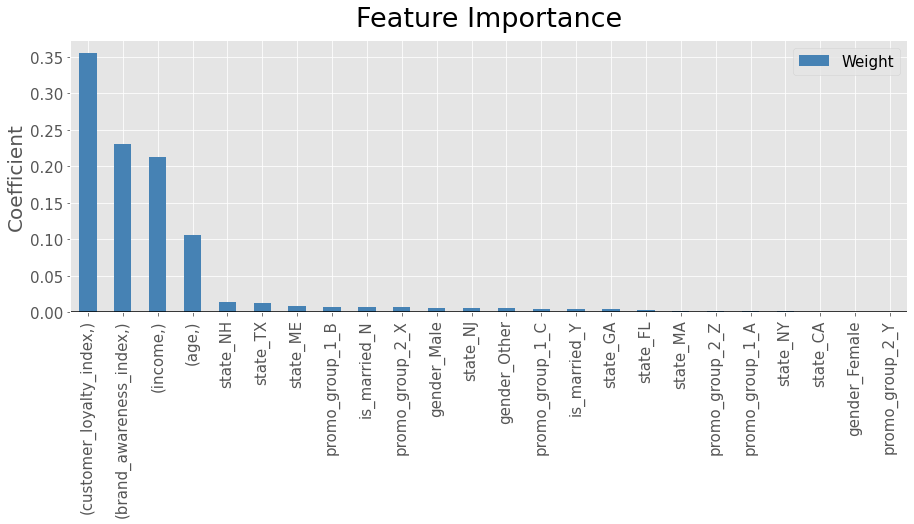

In [21]:
# plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

gbst.fit(X_train, y_train)
importances = pd.DataFrame((gbst.feature_importances_),
                           index=X_train.columns,
                           columns=['Gradient Boosting']).sort_values('Gradient Boosting',
                                                                 ascending=False).rename(columns={'index': 'Feature', 'Gradient Boosting': 'Weight'})

print ()
print ('\033[1m'+'Feature Weights:'+'\033[0m')
print (display(importances.head(30)))



importances.plot(kind='bar', figsize=(15,5), color='steelblue')
plt.title('Feature Importance', fontsize = 27, y = 1.03, color='black')
plt.ylabel('Coefficient', fontsize = 20)
plt.yticks(fontsize = 15)
plt.axhline(0, color='black')
plt.xticks(rotation=90, fontsize = 15)

plt.legend(fontsize = 15)
plt.show()

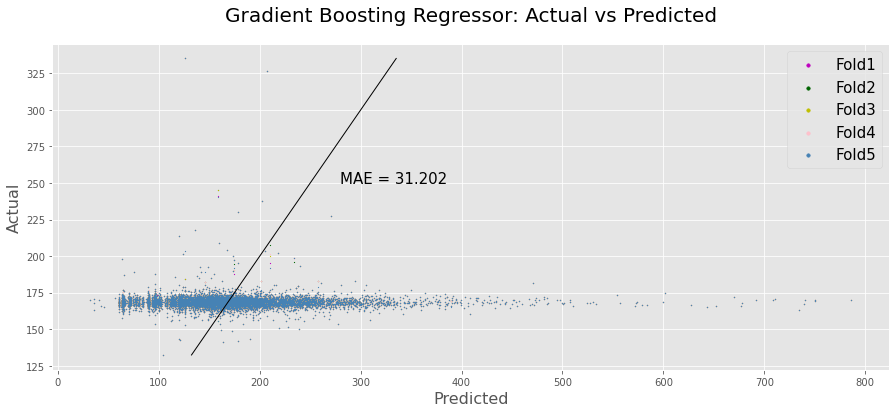

In [22]:
# from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
scores = cross_val_score(gbst, X_train, y_train, cv=cv,scoring='neg_median_absolute_error')

plt.style.use('ggplot')
plt.figure(figsize=(15,6))
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.title('Gradient Boosting Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)


def do_plot(model, m=None):
    for fold, color in zip(cv.split(X), ['m', 'darkgreen', 'y','pink', 'steelblue']):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        plt.scatter(y_test, y_pred, color=color,s=.5 )
        plt.legend(["Fold1", 'Fold2','Fold3',"Fold4", 'Fold5'], fontsize = 15,markerscale=5)
    plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()],color='black', linewidth=1)
    plt.text(280,250, "MAE = "+str(m), fontsize=15)
do_plot(gbst, abs(scores.mean().round(3)))

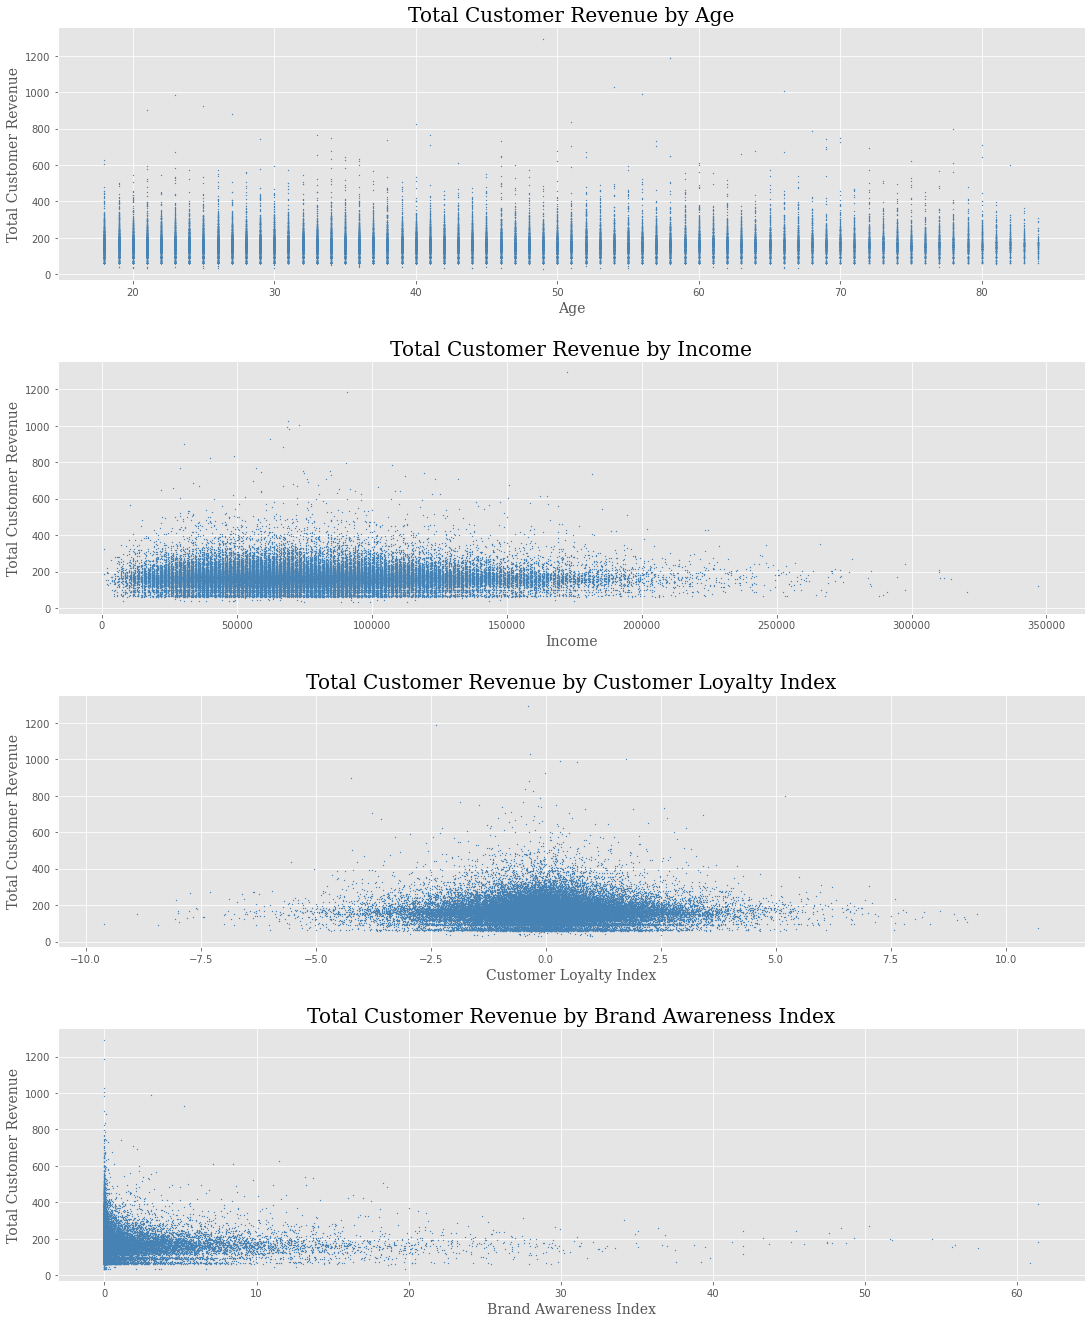

In [23]:
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=4,ncols=1, figsize=(15,18))
plt.tight_layout(h_pad=6)
cont=cont
titles=['Age','Income',\
        'Customer Loyalty Index','Brand Awareness Index']
for ax,feature, title in zip(axes.flat,cont, titles):
        ax.scatter(df[feature], df.transaction_value, color='steelblue',s=.7 )
        ax.set_title('Total Customer Revenue by '+ title ,fontsize=20,family='serif')
        ax.set_xlabel(title,size =14,family='serif')
        ax.set_ylabel('Total Customer Revenue',size =14,family='serif')
plt.show()  

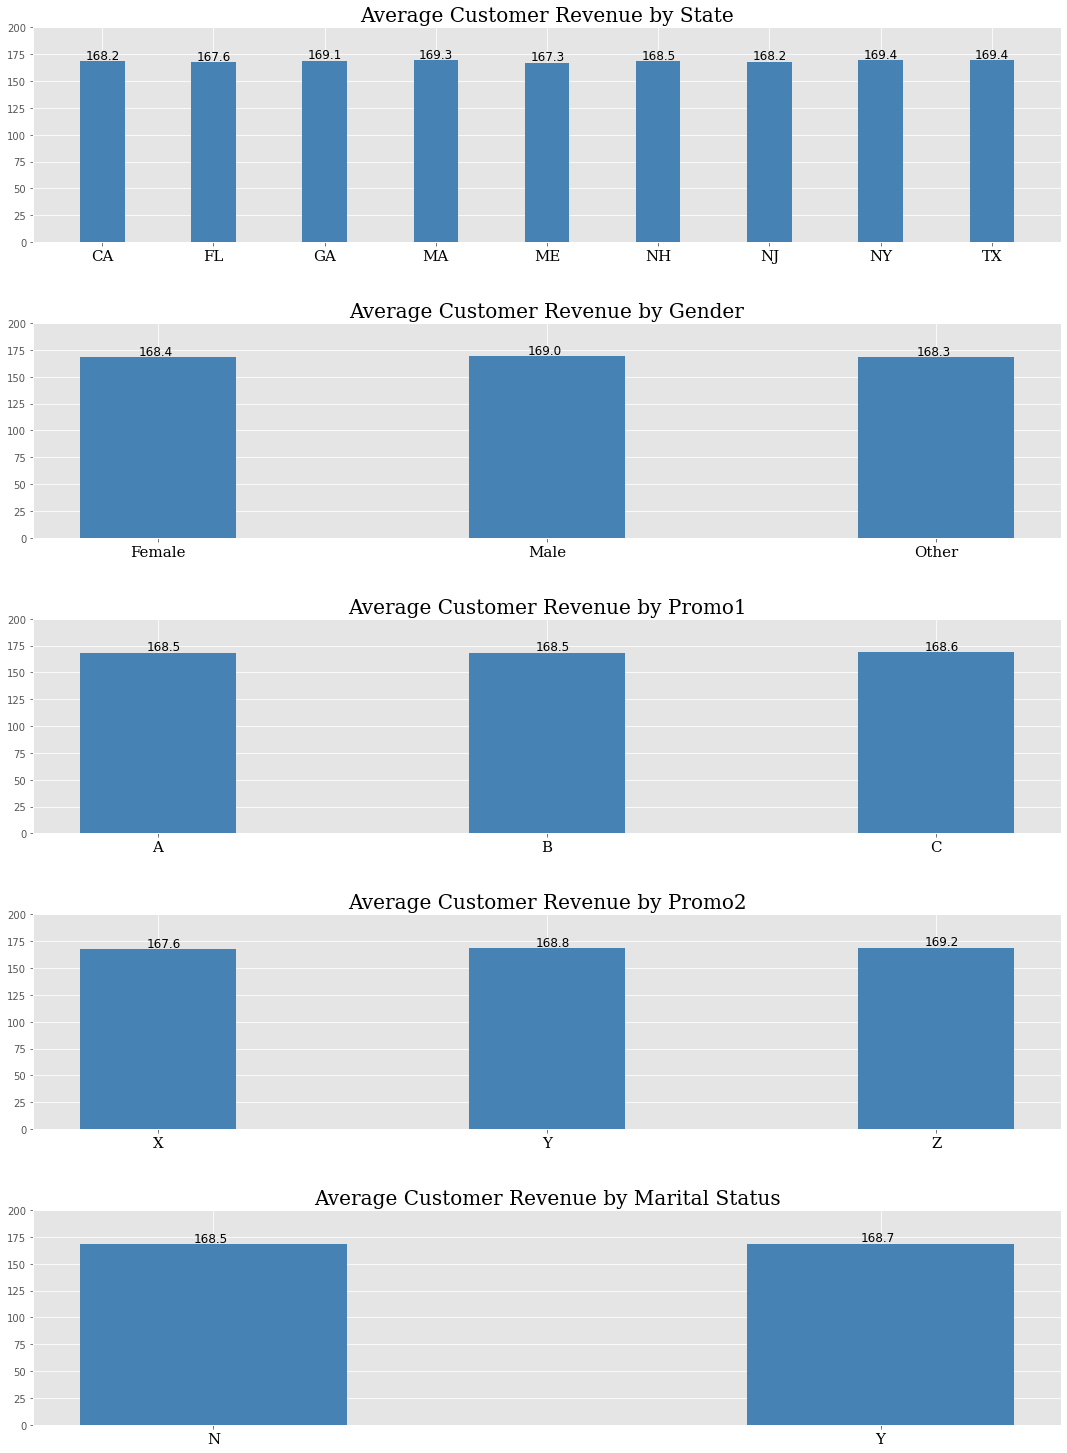

In [24]:
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=5,ncols=1, figsize=(15,20))
plt.tight_layout(h_pad=6)
cat=['state', 'gender', 'promo_group_1', 'promo_group_2','is_married']
titles=['State','Gender',\
        'Promo1','Promo2','Marital Status']

for ax,feature, title in zip(axes.flat,cat, titles):
    df3=pd.pivot_table(df,  values=['transaction_value'], \
                   columns=feature,aggfunc='mean').T.reset_index()
    features = list(df3[feature])
    values = list(df3['transaction_value'])
    ax.bar(features, values, color ='steelblue',
        width = 0.4)
    ax.set_title('Average Customer Revenue by '+ title ,fontsize=20,family='serif')
    ax.set_ylim([0,200])
    if feature=='state':
        for i in ax.patches:
            ax.text( i.get_x()+.05,i.get_height()+2, \
                '{:.1f}'.format(i.get_height()), fontsize=12)
    elif feature=='gender':
            for i in ax.patches:
                ax.text( i.get_x()+.15,i.get_height()+2, \
                '{:.1f}'.format(i.get_height()), fontsize=12)
    elif feature in ['Promo1', 'Promo2']:
        for i in ax.patches:
            ax.text( i.get_x()+.2,i.get_height()+2, \
                '{:.1f}'.format(i.get_height()), fontsize=12)
    else:
            for i in ax.patches:
                ax.text( i.get_x()+.17,i.get_height()+2, \
                '{:.1f}'.format(i.get_height()), fontsize=12)
    ax.set_xticklabels(df3[feature],size =15,family='serif', \
                       color='black', rotation='horizontal')
plt.show()
        